# Exploring the Relationship Between Police Stops and Crime in San Diego: A Microgeographic Analysis of Demographic Factors and Policing Strategies

In recent years, the effectiveness and implications of police stops have been at the center of public debate and academic inquiry. This study aims to contribute to the ongoing discourse by examining the relationship between police stops and crime in San Diego at a microgeographic level. By focusing on regional variations, demographic factors, and community impact, we seek to provide valuable insights into the efficiency and consequences of police stops within the city's diverse police beats. Through a comprehensive analysis of crime patterns and outcomes, our research aims to inform evidence-based recommendations for refining and improving policing strategies in San Diego and other similar urban areas, ultimately fostering more equitable and effective law enforcement practices.

In examining the relationship between police stops and crime, it is important to consider the existing literature on this subject. Miller et al. (2000) found that while stops and searches play some role in fighting crime and lead to about one-tenth of arrests nationally, they have only a small impact on the detection and prevention of recorded or reported crime. Additionally, searches tend to have a negative impact on public confidence in the police, often due to perceived impoliteness and inadequate explanations for stopping individuals. The authors recommend focusing on efficient and targeted use of searches based on intelligence and high levels of suspicion, while emphasizing more serious crimes and prolific offenders.

MacDonald et al. (2016) investigated the effects of the New York Police Department's (NYPD) Operation Impact, which deployed extra police officers to high crime areas. The authors found that impact zones were associated with significant reductions in reported crimes and increases in reported arrests. However, they also noted that the majority of investigative stops did not play an important role in crime reduction, suggesting that more focused investigative stops could be more effective.

Weisburd et al. (2015) explored the impact of stop, question, and frisks (SQFs) on crime in New York City at a microgeographic level. They found that SQFs produce a significant yet modest deterrent effect on crime, but questioned whether other policing strategies might yield similar or stronger crime-control outcomes. They also noted that the level of SQFs needed to achieve meaningful crime reductions can be costly and potentially harmful to police legitimacy.

Petersen et al. (2023) conducted a systematic review and meta-analysis on the effects of police-initiated pedestrian stops on crime and individual-level outcomes. Their findings indicated that pedestrian stop interventions were associated with a statistically significant reduction in crime for treatment areas relative to control areas. However, they also found that such interventions led to a broad range of negative individual-level effects, such as increased odds of mental and physical health issues, more negative attitudes toward the police, and higher levels of self-reported crime and delinquency. The authors concluded that, although pedestrian stop interventions have favorable effects on place-based crime and displacement outcomes, the negative individual-level effects make it difficult to recommend their use over alternative policing interventions.

By examining the relationship between stops and crime within San Diego's police beats, our study will add valuable insights on regional variations in the effectiveness of police stops. This localized focus allows us to compare different areas with varying levels of crime and stops, providing insights that can be used to improve policing strategies. Furthermore, our research will assess the efficiency of police stops in San Diego and explore how well they align with crime levels across different police beats.

Focusing on demographic factors, our study will investigate the role of variables such as race and gender in the relationship between police stops and crime in San Diego. By examining how these factors may influence the patterns and outcomes of stops, we aim to contribute to a deeper understanding of the impact of police practices on different communities and support the development of more equitable policing strategies.

In summary, our study on the relationship between police stops and crime in San Diego will complement and extend the existing literature, offering valuable insights that contribute to a deeper understanding of this relationship and providing evidence-based recommendations for refining and improving policing strategies in San Diego and other similar cities.

### Data Prep

In [52]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from stargazer.stargazer import Stargazer

In [3]:
# Read the crime data
"""
Crime Data has the following columns:
    ['activityNumber', 'activityType', 'activityDate', 'Year',
       'violationSection', 'violationType', 'chargeDescription', 'codeUcr',
       'BlockNumber', 'streetDirection', 'streetName', 'streetType', 'city',
       'state', 'zipCode', 'beat']
"""
crime_data = pd.read_excel('PRA 21-4922_2019-2021_Crimes__UCR Revised.xlsx')

# read the stop data
"""
Stop Data has the following columns:
    ['Unnamed: 0', 'stop_id', 'pid', 'id', 'ori', 'agency', 'exp_years',
       'date', 'time', 'dur', 'is_serv', 'assign_key', 'assign_words',
       'inters', 'block', 'ldmk', 'street', 'hw_exit', 'is_school',
       'school_name', 'city', 'beat', 'beat_name', 'is_student', 'lim_eng',
       'age', 'gender_words', 'is_gendnc', 'gender_code', 'gendnc_code',
       'lgbt', 'race', 'disability', 'reason_words', 'reasonid', 'reason_text',
       'reason_detail', 'reason_exp', 'search_basis', 'search_basis_exp',
       'seiz_basis', 'prop_type', 'cont', 'actions', 'act_consent']
"""
stops_2019 = pd.read_csv('master-ripa-2019.csv')
stops_2020 = pd.read_csv('master-ripa-2020.csv')
stops_2021 = pd.read_csv('master-ripa-2021.csv')

# read the beat demographics data
"""
Beat Demographics Data has the following columns:
    ['beat', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp']
"""
beat_demographics = pd.read_csv('beat_demographics_2019_acs.csv')

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (15,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Combine stops data from 2019, 2020, and 2021
stops_data = pd.concat([stops_2019, stops_2020, stops_2021])

Fix Race Labels in the stop data

In [5]:
# print number of unique race values
print(len(stops_data["race"].unique()))

146


In [6]:
# convert race to string typ
stops_data["race"] = stops_data["race"].astype(str)

In [7]:
len(stops_data["race"].unique())

146

In [8]:
# print first 5 instances of race
stops_data["race"].head()

0          Hispanic/Latino/a
1                      White
2    Hispanic/Latino/a|White
3          Hispanic/Latino/a
4     Black/African American
Name: race, dtype: object

In [9]:
# check if the first 5 have "|" in them
stops_data["race"][0:5].str.contains('\\|', regex=True).sum()

1

In [10]:
multiracial_count = stops_data['race'].str.contains('\\|', regex=True).sum()
total_count = len(stops_data)
print(f"Multiracial count: {multiracial_count} out of {total_count} ({100 * multiracial_count / total_count:.2f}%)")

Multiracial count: 3767 out of 407684 (0.92%)


In [11]:
# count the unique values in the race column that do not contain '\\|'
stops_data["race"][~stops_data["race"].str.contains('\\|', regex=True)].value_counts()

White                            168446
Hispanic/Latino/a                119515
Black/African American            81387
Asian                             19647
Middle Eastern or South Asian     11001
Pacific Islander                   3112
Native American                     809
Name: race, dtype: int64

In [12]:
def simplify_race(race):
    if 'White' in race:
        return 'white'
    elif 'Black/African American' in race:
        return 'black'
    elif 'Asian' in race:
        return 'asian'
    elif 'Hispanic/Latino/a' in race:
        return 'hisp'
    elif 'Native American' in race:
        # https://www.census.gov/programs-surveys/acs/data/race-aian.html
        return 'aian'
    elif 'Pacific Islander' in race:
        return 'nhopi'
    elif 'Middle Eastern or South Asian' in race:
        return 'other'
    else:
        return 'other'

In [13]:
# apply the simplify_race function to the race column
stops_data["race"] = stops_data["race"].apply(simplify_race)

Add other race to demographic data

In [14]:
beat_demographics['other'] = beat_demographics['total'] - (
    beat_demographics['white'] + 
    beat_demographics['black'] + 
    beat_demographics['aian'] + 
    beat_demographics['asian'] + 
    beat_demographics['nhopi'] + 
    beat_demographics['hisp']
)

In [15]:
# Group crime and stops data by beat
crime_by_beat = crime_data.groupby('beat').size().reset_index(name='num_crimes')
stops_by_beat = stops_data.groupby(['beat', 'race']).size().reset_index(name='num_stops')

# Merge crime and stops data by beat
crime_stops_by_beat = pd.merge(crime_by_beat, stops_by_beat, on='beat')

# Merge crime_stops_by_beat with beat_demographics
crime_stops_demographics_by_beat = pd.merge(crime_stops_by_beat, beat_demographics, on='beat')

# Calculate the ratio of stops to crimes in each beat
crime_stops_demographics_by_beat['stops_to_crimes_ratio'] = crime_stops_demographics_by_beat['num_stops'] / crime_stops_demographics_by_beat['num_crimes']

# Calculate the proportion of stops for each racial group in each beat
racial_groups = ['white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']
for group in racial_groups:
    crime_stops_demographics_by_beat[f'{group}_stops_proportion'] = crime_stops_demographics_by_beat.loc[crime_stops_demographics_by_beat['race'] == group, 'num_stops'] / crime_stops_demographics_by_beat[group]

In [16]:
# Display the results
print(crime_stops_demographics_by_beat.sort_values(by='stops_to_crimes_ratio', ascending=False))

      beat  num_crimes   race  num_stops  total  white  black  aian  asian  \
155  316.0          36  white        245   1163    691     57     3    102   
516  714.0         231   hisp       1098    194      4      5     0      6   
500  711.0          33   hisp        125   8205    482    243     0    397   
432  614.0        2277  white       7985  10937   8657    260    14    314   
92   235.0          32  white        100   2654   1591     35     0    324   
..     ...         ...    ...        ...    ...    ...    ...   ...    ...   
70   232.0         845   aian          1  11531   5652    204     8   4089   
53   124.0        3401   aian          4  30257  22649    552     8   2980   
104  243.0         931   aian          1   6173   2021    275    45   2134   
543  725.0        1077   aian          1   4999    881    541    16    954   
23   115.0        4017   aian          2  49954  24314    871   220  16481   

     nhopi  hisp  other  stops_to_crimes_ratio  white_stops_pro

In [17]:
# print the data for beat 316
crime_stops_demographics_by_beat[crime_stops_demographics_by_beat['beat'] == 935]

,beat,num_crimes,race,num_stops,total,white,black,aian,asian,nhopi,hisp,other,stops_to_crimes_ratio,white_stops_proportion,black_stops_proportion,aian_stops_proportion,asian_stops_proportion,nhopi_stops_proportion,hisp_stops_proportion,other_stops_proportion
706,935.0,251,asian,81,9513,5535,25,6,2731,16,706,494,0.322709,NaN,NaN,NaN,0.029659,NaN,NaN,NaN
707,935.0,251,black,42,9513,5535,25,6,2731,16,706,494,0.167331,NaN,1.68,NaN,NaN,NaN,NaN,NaN
708,935.0,251,hisp,132,9513,5535,25,6,2731,16,706,494,0.525896,NaN,NaN,NaN,NaN,NaN,0.186969,NaN
709,935.0,251,nhopi,4,9513,5535,25,6,2731,16,706,494,0.015936,NaN,NaN,NaN,NaN,0.25,NaN,NaN
710,935.0,251,white,432,9513,5535,25,6,2731,16,706,494,1.721116,0.078049,NaN,NaN,NaN,NaN,NaN,NaN


### Simple Analysis

In [35]:
# group num_stops by beat and num_crimes and drop the race column only keep beat, num_crimes, and num_stops
model1_data = crime_stops_by_beat.groupby(['beat', 'num_crimes']).sum().reset_index()

Regression with the number of stops as the dependent variable and the number of crimes as the independent variable:


In [39]:
model1_linear = smf.ols(formula='num_stops ~ num_crimes', data=model1_data).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.740
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     349.3
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           9.64e-38
Time:                        02:52:03   Log-Likelihood:                -1135.5
No. Observations:                 125   AIC:                             2275.
Df Residuals:                     123   BIC:                             2281.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -408.2078    274.739     -1.486      0.1

In [34]:
model1 = smf.poisson("num_stops ~ num_crimes", data=model1_data).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 480.601175
         Iterations 9
                          Poisson Regression Results                          
Dep. Variable:              num_stops   No. Observations:                  125
Model:                        Poisson   Df Residuals:                      123
Method:                           MLE   Df Model:                            1
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.7184
Time:                        02:45:10   Log-Likelihood:                -60075.
converged:                       True   LL-Null:                   -2.1337e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.2392      0.002   2926.522      0.000       7.234       7.244
num_crimes     0.0005   7.9

Regression including demographic variables

In [41]:
# group by crime_stops_demographics_by_beat by beat	num_crimes	num_stops	total	white	black	aian	asian	nhopi	hisp	other
model2_data = crime_stops_demographics_by_beat.groupby(['beat', 'num_crimes', 'num_stops', 'total', 'white', 'black', 'aian', 'asian', 'nhopi', 'hisp', 'other']).sum().reset_index()

In [48]:
model2 = smf.poisson("num_stops ~ num_crimes + white + black + hisp + aian +asian + hisp+ other", data=model2_data).fit(maxiter=1000)
print(model2.summary())


Optimization terminated successfully.
         Current function value: 409.693855
         Iterations 76
                          Poisson Regression Results                          
Dep. Variable:              num_stops   No. Observations:                  717
Model:                        Poisson   Df Residuals:                      709
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.3462
Time:                        02:57:38   Log-Likelihood:            -2.9375e+05
converged:                       True   LL-Null:                   -4.4932e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.4334      0.003   1829.385      0.000       5.428       5.439
num_crimes     0.0006   1.

In [43]:
model2_linear = smf.ols(formula='num_stops ~ num_crimes + white + black + hisp + aian +asian + hisp+ other', data=model2_data).fit()
print(model2_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     33.58
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           1.88e-40
Time:                        02:55:09   Log-Likelihood:                -6032.9
No. Observations:                 717   AIC:                         1.208e+04
Df Residuals:                     709   BIC:                         1.212e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.5564     67.201     -0.157      0.8

Regression with interaction terms to explore the relationship between stops, crimes, and racial composition

In [53]:
model3_data = model2_data.copy()
model3_data['num_crimes_scaled'] = np.log1p(model3_data['num_crimes'])
model3_data['white_ratio'] = model3_data['white'] / model3_data['total']
model3_data['black_ratio'] = model3_data['black'] / model3_data['total']
model3_data['hisp_ratio'] = model3_data['hisp'] / model3_data['total']

In [54]:
model3 = smf.poisson("num_stops ~ num_crimes_scaled * white_ratio + num_crimes_scaled * black_ratio + num_crimes_scaled * hisp_ratio", data=model3_data).fit()
print(model3.summary())

Optimization terminated successfully.
         Current function value: 392.842705
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:              num_stops   No. Observations:                  717
Model:                        Poisson   Df Residuals:                      709
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Mar 2023   Pseudo R-squ.:                  0.3731
Time:                        03:04:11   Log-Likelihood:            -2.8167e+05
converged:                       True   LL-Null:                   -4.4932e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         4.2267      0.126     33.650      

In [55]:
model3_linear = smf.ols(formula='num_stops ~ num_crimes_scaled * white_ratio + num_crimes_scaled * black_ratio + num_crimes_scaled * hisp_ratio', data=model3_data).fit()
print(model3_linear.summary())

                            OLS Regression Results                            
Dep. Variable:              num_stops   R-squared:                       0.141
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     16.60
Date:                Wed, 29 Mar 2023   Prob (F-statistic):           2.40e-20
Time:                        03:04:41   Log-Likelihood:                -6081.1
No. Observations:                 717   AIC:                         1.218e+04
Df Residuals:                     709   BIC:                         1.221e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

Regression Result Summary

In [58]:
stargazer = Stargazer([model1, model1_linear, model2, model2_linear, model3, model3_linear])
stargazer.title("Regression Results")
stargazer.custom_columns(['Poisson 1', 'Linear 1', 'Poisson 2', 'Linear 2', 'Poisson 3', 'Linear 3'], [1, 1, 1, 1, 1, 1])

from IPython.core.display import HTML
HTML(stargazer.render_html())

## Visualize the data

In [18]:
# Read the shapefile
shapefile_path = 'pd_beats_datasd/pd_beats_datasd.shp'
beat_geodata = gpd.read_file(shapefile_path)

In [19]:
# Convert beat column to numeric
beat_geodata['beat'] = pd.to_numeric(beat_geodata['beat'])

In [20]:
# Aggregate the stop data by beat (replace 'count' with the column of interest)
aggregated_stops = stops_data.groupby(['beat']).size().reset_index(name='count')

# Merge the geodata with the aggregated stop data
merged_geodata = beat_geodata.merge(aggregated_stops, on='beat')

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


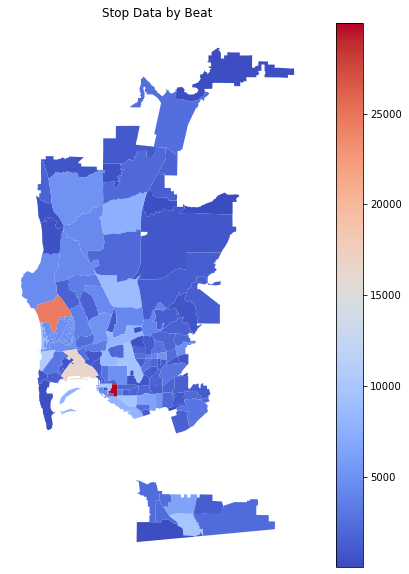

In [21]:
# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
merged_geodata.plot(column='count', cmap='coolwarm', legend=True, ax=ax)
ax.set_title('Stop Data by Beat')
ax.set_axis_off()
plt.show()

## TODO: EDA
Descriptive Statistics:
- Calculate summary statistics (mean, median, mode, standard deviation) for the number of stops and crimes by beat.
- Analyze the distribution of stops and crimes by race and beat.
- Investigate the temporal trends of stops and crimes (daily, weekly, monthly, or yearly).

Visualizations
- Create bar plots or pie charts to show the distribution of stops and crimes by race.
- Generate line plots or bar plots to visualize the trends of stops and crimes over time (by beat or overall).
- Use heatmaps to display the correlation between stops and crimes by beat or by race.
- Plot a time series of stops and crimes to identify any patterns or seasonality.
- Create box plots or violin plots to visualize the distribution of stops and crimes by beat or race.

### Data Profiling

In [22]:
# use pandas profiling to generate a report of the stops data
profile = ProfileReport(stops_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# save the report to html
profile.to_file("stops_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\scipy\stats\stats.py:4814: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var) / np.sqrt(2)))
c:\Users\Ahmad\anaconda3\envs\green\lib\site-packages\pandas_profiling\model\correlations.py:61: UserWarning: There was an attempt to calculate the cramers correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"cramers": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/pandas-profiling/pandas-profiling/issues
(include the error message: 'No data; `observed` has size 0.')
  (include the error message: '{error}')"""


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
# use pandas profiling to generate a report of the crime data
profile = ProfileReport(crime_data, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# save the report to html
profile.to_file("crime_data_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Data Set Summary

The data used in this project spans multiple years (2019-2021) and is derived from various sources.

The primary datasets used in the analysis are the stop data files, which include information on stops conducted by SDPD for the years 2019, 2020, and 2021. These files provide comprehensive data on each stop, such as the location, demographics of the person stopped, reason for the stop, and other relevant details. The stop data is collected under the Racial and Identity Profiling Act of 2015 (RIPA), which requires nearly all California law enforcement agencies to submit demographic data on all detentions and searches. This data is publicly available and can be downloaded from the City of San Diego's data portal: https://data.sandiego.gov/datasets/police-ripa-stops/. By combining these files, a complete picture of police stops over the three years can be obtained.

To gain insights into the spatial distribution of police stops, **shapefiles for SDPD beats** are used. These files contain the geographic boundaries of police beats, which are essential for visualizing and understanding the spatial patterns of stops and crimes in San Diego.

Additionally, **population data** for each beat is incorporated into the analysis. This data is sourced from the U.S. Census Bureau's American Community Survey (ACS) for 2019, which provides demographic information, including the racial composition of residents within each beat. By including this data, potential racial biases in police stops can be identified and examined.

Finally, a dataset containing all crimes reported to the SDPD between 2019 and 2021 is utilized. This data was obtained under the California Public Records Act (PRA) by the San Diego Union-Tribune and is essential for understanding the relationship between police stops and crime incidents in San Diego. By merging this dataset with the stop data and beat demographics, a comprehensive analysis of the spatial and demographic aspects of police stops can be conducted.

**So far**, the project has focused on cleaning, preprocessing, and merging the datasets to facilitate the analysis. Additionally, some preliminary visualizations have been created to explore the spatial distribution of police stops and crime incidents across San Diego. Furthermore, several regression models have been suggested to investigate the relationship between police stops, crime incidents, and demographic variables, including both Poisson and linear regression models. These models will be used to provide a more in-depth understanding of the factors influencing police stops in San Diego and whether they align with the occurrence of crime incidents.

### References
Papers
- https://www.ojp.gov/ncjrs/virtual-library/abstracts/impact-stops-and-searches-crime-and-community
- https://onlinelibrary.wiley.com/doi/10.1111/1745-9133.12172
- https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0157223
- https://onlinelibrary.wiley.com/doi/10.1002/cl2.1302

Articles
- https://www.vera.org/newsroom/study-reveals-stop-and-frisk-significantly-impacts-trust-in-new-york-city-police
- https://gothamist.com/news/new-york-city-police-have-stopped-and-questioned-more-people-this-year-than-last-as-mayor-adams-cracks-down-on-crime


